In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Ielādē apmācību un testa datus
df = pd.read_csv('dati_fin.csv', sep=';')
df_test = pd.read_csv('2024_fin.csv', sep=';')

In [ ]:
# No apmācības un testa datu kopām atdala kolonnu 'Darījuma summa, EUR'
x_train = df.drop(columns=['Darījuma summa, EUR']) 
y_train = df['Darījuma summa, EUR'] 
x_test = df_test.drop(columns=['Darījuma summa, EUR'])
y_test_actual = df_test['Darījuma summa, EUR'] 

In [ ]:
# Definē hiperparametru režģi GridSearchCV funkcijai
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 7, 10],
}

# Izveido XGBoost regresijas modeli
xgb_reg = xgb.XGBRegressor(random_state=42)

# Ar GridSearchCV veic labāko parametru meklēšanu
grid_search = GridSearchCV(xgb_reg, param_grid, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train) # Apmāca modeli ar apmācības datiem

# Iegūst un izdrukā labākos parametrus
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7}


In [5]:
# Izveido XGBoost regresijas modeli, izmantojot labākos atrastos parametrus
best_xgb_reg = xgb.XGBRegressor(**best_params, random_state=42)
# Apmāca šo modeli ar apmācību datiem
best_xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
# Izmanto apmācīto modeli, lai prognozētu cenas testa datiem
y_test_pred = best_xgb_reg.predict(x_test)

In [7]:
# Novērtē modeļa precizitāti uz testa datiem
mae = mean_absolute_error(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_test_pred)

# Aprēķina relatīvās kļūdas
relative_errors = np.abs(y_test_pred - y_test_actual) / y_test_actual
mre = np.max(relative_errors)
are = np.mean(relative_errors)

In [8]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MRE: {mre}")
print(f"ARE: {are}")

MAE: 15629.554819805044
MSE: 752510112.0308307
RMSE: 27431.91776071864
R^2: 0.8468684198142112
MRE: 13.3252265625
ARE: 0.32761206495451656


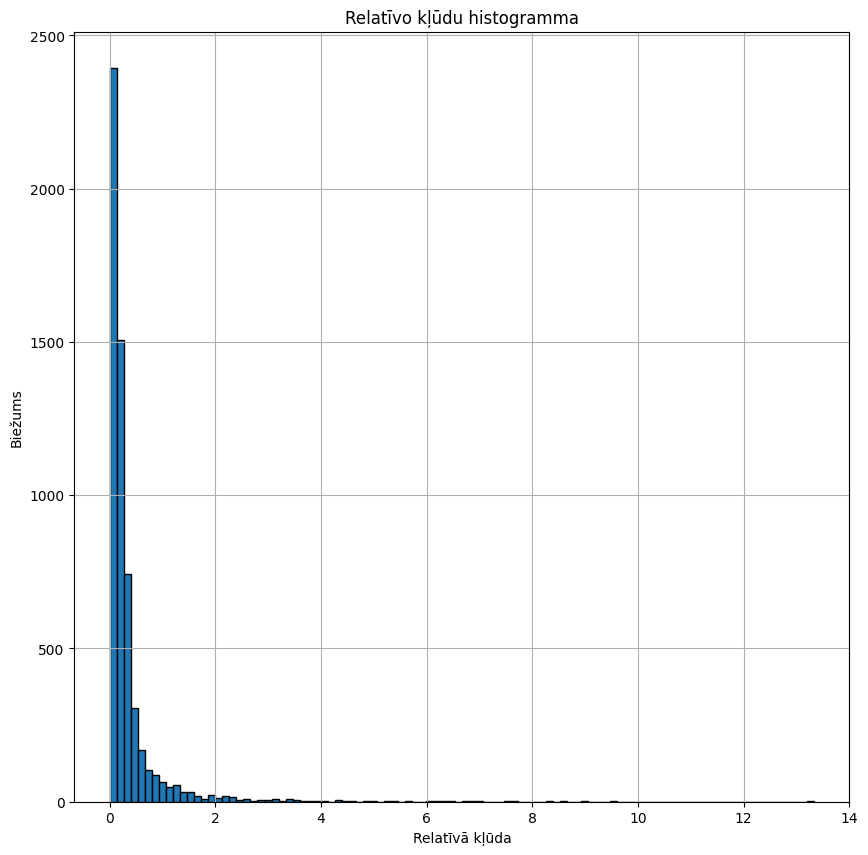

In [ ]:
# Izveido relatīvo kļūdu histogrammu
plt.figure(figsize=(10, 10))
# Histogrammas dati tiek sadalīti 100 intervālos (stabiņos)
plt.hist(relative_errors, bins=100, edgecolor='black')

# Izveido X ass atzīmes no 0 līdz max kļūdai ik pa 2
xticks = np.arange(0, mre + 2, 2)
plt.xticks(xticks)

plt.title('Relatīvo kļūdu histogramma')
plt.xlabel('Relatīvā kļūda')
plt.ylabel('Biežums')
plt.grid(True)
plt.show()

In [10]:
# df_test tiek pievienotas divas jaunas kolonnas
df_test['Prognozētā summa'] = y_test_pred
df_test['Relatīvā kļūda'] = relative_errors

# Sakārtoto datu kopu pēc relatīvās kļūdas, sākot ar lielāko kļūdu
df_test_sort = df_test.sort_values(by='Relatīvā kļūda', ascending=False)

# Izveido jaunu datu kopu, kurā ir tikai trīs kolonnas
kludas = df_test_sort[['Darījuma summa, EUR', 'Prognozētā summa', 'Relatīvā kļūda']]

# Saglabā datus CSV failā
kludas.to_csv('xgb_rel_err.csv', sep=';', index=False)